In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import extract_correct_csv
import neurokit2 as nk
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## All valid subject

In [2]:
valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_subject

[2, 4, 10, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

In [3]:
columns = list(pd.read_csv('../osf-storage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_

In [4]:
generic_df = pd.DataFrame(columns=columns)
for x in valid_subject:
    cur_sub = extract_correct_csv.read_correct_subject_csv(x)
    subject = pd.read_csv('data/LookAtMe_0'+cur_sub+'.csv', sep='\t')
    pupil_subj = pd.read_csv('../osf-storage-archive/eye/pupil/Look0'+cur_sub+'_pupil.csv', sep=';', decimal=',')
    expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
    df_ = pupil_subj.copy(deep=False)
    df_['expectancy'] = expectancy
    df_['shock'] = subject['shock']
    generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])

In [5]:
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]

In [6]:
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
mean_baseline

2.3951070719941048

In [7]:
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)-mean_baseline
all_conf_1 = df_LE_shock.var(axis=0)/np.sqrt(len(X))

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)-mean_baseline
all_conf_2 = df_LE_no_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)-mean_baseline
all_conf_3 = df_HE_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)-mean_baseline
all_conf_4 = df_HE_no_shock.std(axis=0)/np.sqrt(len(X))


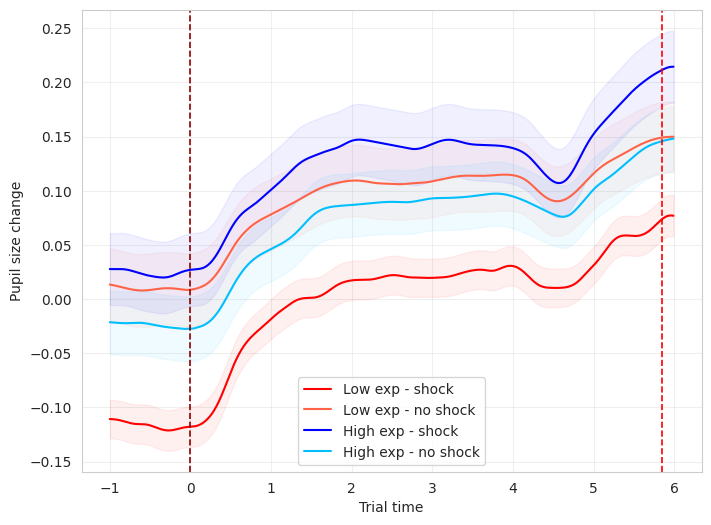

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color = 'r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color = 'tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color = 'b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color = 'deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## Single signal eda

In [9]:
valid_subject = extract_correct_csv.extract_only_valid_subject()

not_valid = {4, 43, 45, 50}

valid_subject = [ele for ele in valid_subject if ele not in not_valid]

In [10]:
subject = pd.read_csv('data/sync_signals/eda_csv/2_eda.csv')
shock = pd.read_csv('csv_shock.csv')
shock = shock.drop(columns=shock.columns[0])

eda_processed = []

for x in range(len(subject)):
    row = subject.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

In [11]:
df_eda = eda_processed.copy(deep=False)
shock_sub = shock[shock.subject==2]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda['expectancy'] = expectancy
df_eda['shock'] = shock_sub['shock']
df_eda = df_eda[48:]

In [12]:
X = np.arange(0, 6, 0.002)
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_sing_LE_shock = df_EDA_LE_shock.var(axis=0)

# - low exp and no shock
df_EDA_LE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_no= df_EDA_LE_no.mean(axis=0)
conf_sing_LE_no = df_EDA_LE_no.var(axis=0)

# - high exp and shock
df_EDA_HE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_sing_HE_shock = df_EDA_HE_shock.var(axis=0)

# - high exp and no shock
df_EDA_HE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_no = df_EDA_HE_no.mean(axis=0)
conf_sing_HE_no = df_EDA_HE_no.var(axis=0)

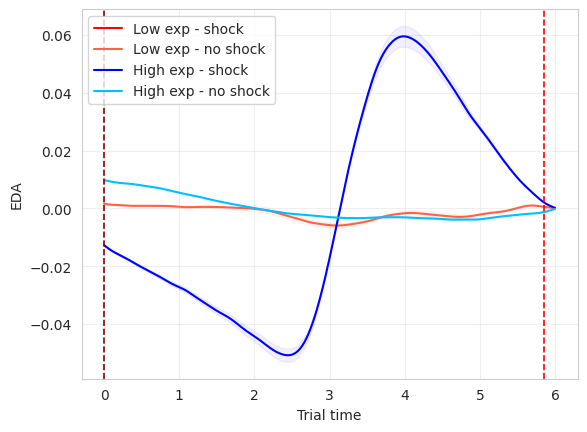

In [13]:
plt.plot(X, mean_sing_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_sing_LE_shock - conf_sing_LE_shock, mean_sing_LE_shock + conf_sing_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_sing_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_sing_LE_no - conf_sing_LE_no, mean_sing_LE_no + conf_sing_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_sing_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_sing_HE_shock - conf_sing_HE_shock, mean_sing_HE_shock + conf_sing_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_sing_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_sing_HE_no - conf_sing_HE_no, mean_sing_HE_no + conf_sing_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.show()

## All subjects EDA

In [14]:
columns_eda = list(eda_processed.columns)
col_ = ['expectancy', 'shock']
columns_eda = columns_eda + col_

In [15]:
global_eda = pd.DataFrame(columns=columns_eda)
for i in valid_subject:
    subject = pd.read_csv('data/sync_signals/eda_csv/'+str(i)+'_eda.csv')
    shock = pd.read_csv('csv_shock.csv')
    shock = shock.drop(columns=shock.columns[0])
    eda_processed = []
    for x in range(len(subject)):
        row = subject.loc[x]
        signals, info = nk.eda_process(row, sampling_rate=500)
        eda_processed.append(signals['EDA_Phasic'].to_numpy())
    eda_processed = pd.DataFrame(eda_processed)
    df_eda_all = eda_processed.copy(deep=False)
    shock_sub = shock[shock.subject==i]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_eda_all['expectancy'] = expectancy
    df_eda_all['shock'] = shock_sub['shock']
    global_eda = pd.concat([global_eda, df_eda_all], axis=0)


In [16]:
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_all_LE_shock = df_EDA_LE_shock.std(axis=0)

# - low exp and no shock
df_EDA_LE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_no= df_EDA_LE_no.mean(axis=0)
conf_all_LE_no = df_EDA_LE_no.std(axis=0)

# - high exp and shock
df_EDA_HE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_all_HE_shock = df_EDA_HE_shock.std(axis=0)

# - high exp and no shock
df_EDA_HE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_no = df_EDA_HE_no.mean(axis=0)
conf_all_HE_no = df_EDA_HE_no.std(axis=0)

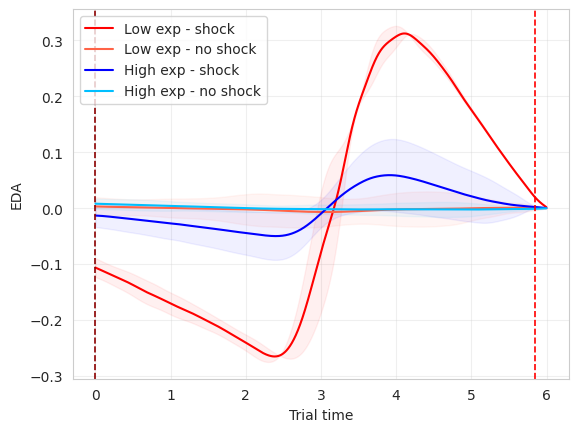

In [17]:
plt.plot(X, mean_all_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_all_LE_shock - conf_all_LE_shock, mean_all_LE_shock + conf_all_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_all_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_all_LE_no - conf_all_LE_no, mean_all_LE_no + conf_all_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_all_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_all_HE_shock - conf_all_HE_shock, mean_all_HE_shock + conf_all_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_all_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_all_HE_no - conf_all_HE_no, mean_all_HE_no + conf_all_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.show()